## <center>ヒノキ現生材<br><br>Hinoki Control

In [2]:
import numpy as np
import matplotlib.pyplot as plt
Lab_ctrl = np.load(r'data\Control.npy')

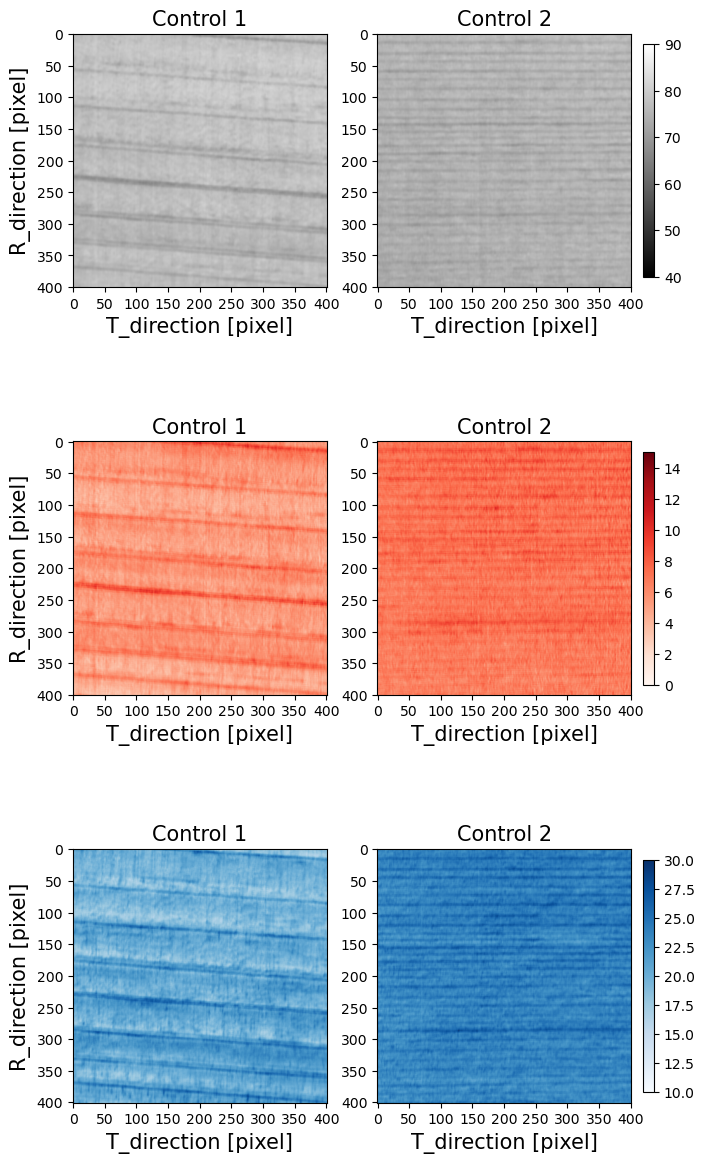

In [3]:
palette = ['binary_r', 'Reds', 'Blues']
color_scales = [{'vmin': 40, 'vmax': 90}, {'vmin': 0, 'vmax': 15}, {'vmin': 10, 'vmax': 30}]

fig, ax = plt.subplots(3, 2, figsize=(7.5, 15))
for i in range(3):
    data = Lab_ctrl[:, :, i, :]
    cmap = palette[i]
    scale = color_scales[i]
    for j in range(2):
        im = ax[i, j].imshow(data[:, :, j], cmap=cmap, **scale)
        ax[i, j].set_title(f'Control {j + 1}', fontsize=15)
        ax[i, j].set_xlabel('T_direction [pixel]', fontsize=15)
        ax[i, j].set_xticks(np.arange(0, 401, 50))
        ax[i, j].set_yticks(np.arange(0, 401, 50))
    ax[i, 0].set_ylabel('R_direction [pixel]', fontsize=15)
    cbar = fig.colorbar(im, ax=ax[i], orientation='vertical', fraction=0.02, pad=0.02);

In [4]:
def standardize(data):
    direction_mean, direction_std = [], []
    for i in range(2):
        flat = data[:, :, i].flatten()
        mean = flat.mean()
        std = flat.std()
        direction_mean.append(mean)
        direction_std.append(std)
    
    data_standardized = []
    for i in range(2):
        standardized = (data[:, :, i].copy() - direction_mean[i]) / direction_std[i]
        data_standardized.append(standardized)
        
    result = np.stack(data_standardized, axis=-1)        
    return result

In [5]:
L_ctrl_sc = standardize(Lab_ctrl[:, :, 0, :])
a_ctrl_sc = standardize(Lab_ctrl[:, :, 1, :])
b_ctrl_sc = standardize(Lab_ctrl[:, :, 2, :])
Lab_ctrl_sc = np.stack([L_ctrl_sc, a_ctrl_sc, b_ctrl_sc], axis=-1)

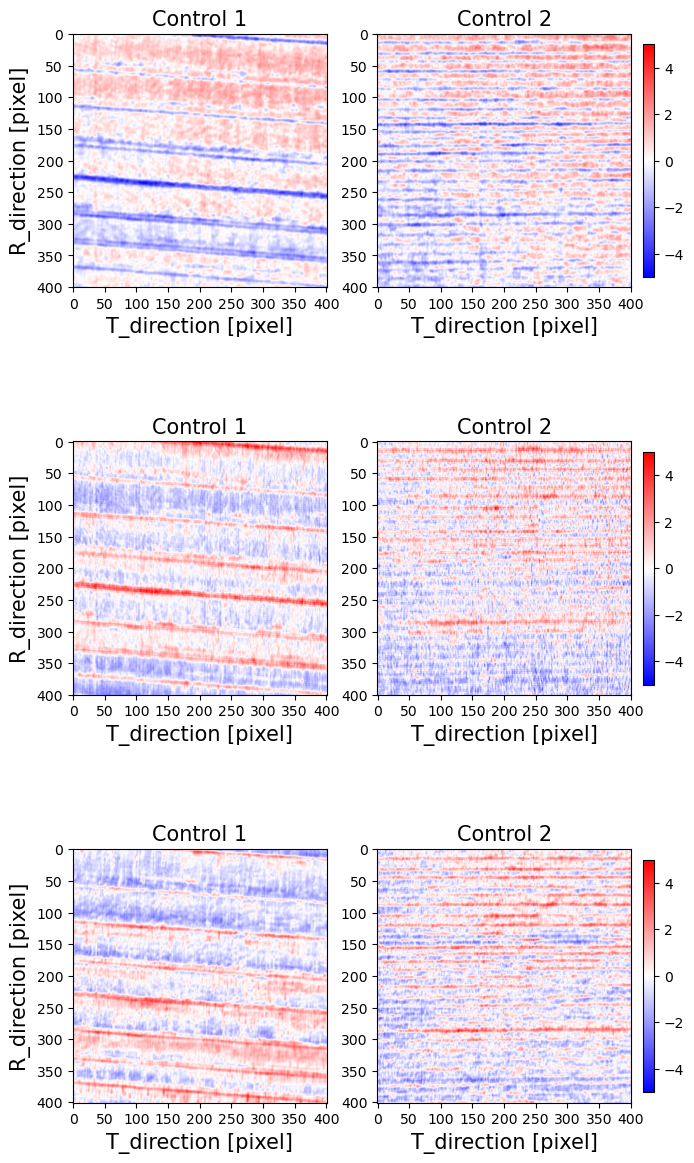

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(7.5, 15))
for i in range(3):
    data = Lab_ctrl_sc[:, :, :, i]
    for j in range(2):
        im = ax[i, j].imshow(data[:, :, j], cmap='bwr', vmin=-5, vmax=5)
        ax[i, j].set_title(f'Control {j + 1}', fontsize=15)
        ax[i, j].set_xlabel('T_direction [pixel]', fontsize=15)
        ax[i, j].set_xticks(np.arange(0, 401, 50))
        ax[i, j].set_yticks(np.arange(0, 401, 50))
    ax[i, 0].set_ylabel('R_direction [pixel]', fontsize=15)
    cbar = fig.colorbar(im, ax=ax[i], orientation='vertical', fraction=0.02, pad=0.02);

In [7]:
mask = Lab_ctrl_sc < 0

A = mask[:, :, :, 0]
B = mask[:, :, :, 1]
C = mask[:, :, :, 2]

class0 = np.logical_and(np.logical_and(A, B), C)
class1 = np.logical_and(np.logical_and(A, ~B), C)
class2 = np.logical_and(np.logical_and(A, B), ~C)
class3 = np.logical_and(np.logical_and(A, ~B), ~C)
class4 = np.logical_and(np.logical_and(~A, B), C)
class5 = np.logical_and(np.logical_and(~A, B), ~C)
class6 = np.logical_and(np.logical_and(~A, ~B), C)
class7 = np.logical_and(np.logical_and(~A, ~B), ~C)
                        
classes = np.zeros(A.shape, dtype=int)

classes[class0] = 0
classes[class1] = 1
classes[class2] = 2
classes[class3] = 3
classes[class4] = 4
classes[class5] = 5
classes[class6] = 6
classes[class7] = 7

In [8]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

turbo_discrete = cm.turbo(np.linspace(0, 1, 8))
turbo_discrete_cmap = ListedColormap(turbo_discrete)

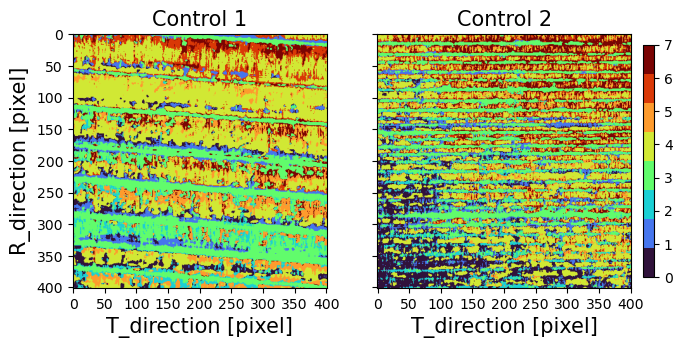

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(7.5, 5), sharey=True)
for i in range(2):
    im = ax[i].imshow(classes[:, :, i], cmap=turbo_discrete_cmap)
    ax[i].set_title(f'Control {i + 1}', fontsize=15)
    ax[i].set_xlabel('T_direction [pixel]', fontsize=15)
    ax[i].set_xticks(np.arange(0, 401, 50))
    ax[i].set_yticks(np.arange(0, 401, 50))

ax[0].set_ylabel('R_direction [pixel]', fontsize=15)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_ticks(np.arange(0, 8))

In [10]:
import statsmodels.api as sm

mask = []
for i in range(8):
    maski = np.zeros((401, 401, 2))
    maski[classes == i] = 1
    mask.append(maski)

def extract_classes(data):
    data_classes = []
    for i in range(8):
        datai = data * mask[i]
        datai = datai.flatten()
        datai = datai[datai != 0]
        data_classes.append(datai)
    return data_classes

L_classes = extract_classes(Lab_ctrl_sc[:, :, :, 0])
a_classes = extract_classes(Lab_ctrl_sc[:, :, :, 1])
b_classes = extract_classes(Lab_ctrl_sc[:, :, :, 2])

def KDE(data):
    x = []
    y = []
    for i in range(8):
        kde_model = sm.nonparametric.KDEUnivariate(data[i])
        kde_model.fit()
        x.append(kde_model.support)
        y.append(kde_model.density)
    return x, y

L_support, L_kde = KDE(L_classes)
a_support, a_kde = KDE(a_classes)
b_support, b_kde = KDE(b_classes)

### クラスごとの L_star [standardized] 密度曲線

In [12]:
def plot_classKDE(class_num: int, data_support, data_kde, tt, ax):
    ax.fill_between(data_support[class_num], data_kde[class_num], color=turbo_discrete_cmap.colors[class_num], label=f'Class{class_num}', alpha=0.8)
    ax.legend(loc='upper right')
    ax.set_facecolor('#A9A9A9')
    ax.set_xlim(-6, 6)
    ax.set_ylim(0, 2.0)
    ax.set_xlabel(f'{tt} [standardized]', fontsize=15)
    ax.set_ylabel(f'Class{class_num} Density', fontsize=15);

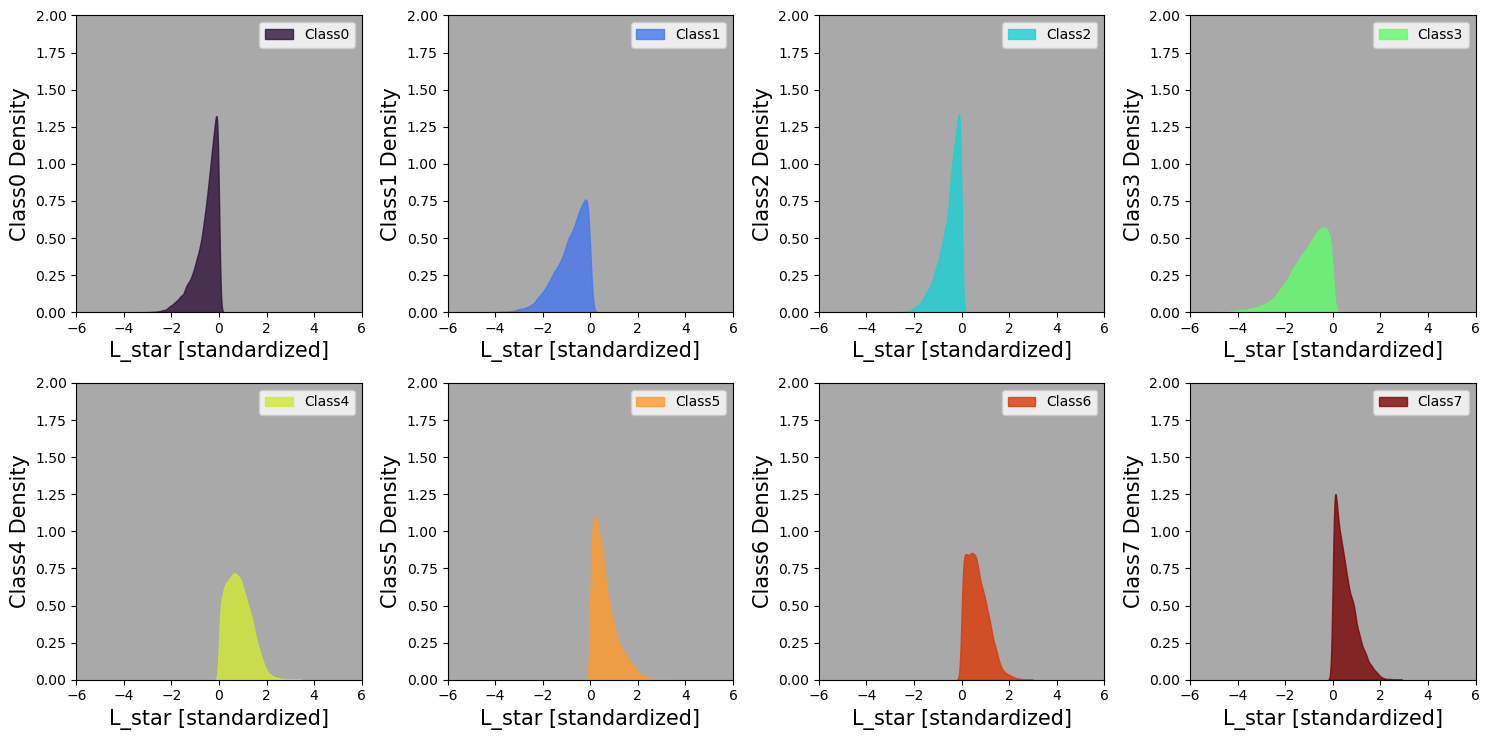

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7.5))
ax = ax.flatten()
for i in range(8):
    plot_classKDE(class_num=i, data_support=L_support, data_kde=L_kde, tt='L_star', ax=ax[i])
plt.tight_layout();

### クラスごとの a_star [standardized] 密度曲線

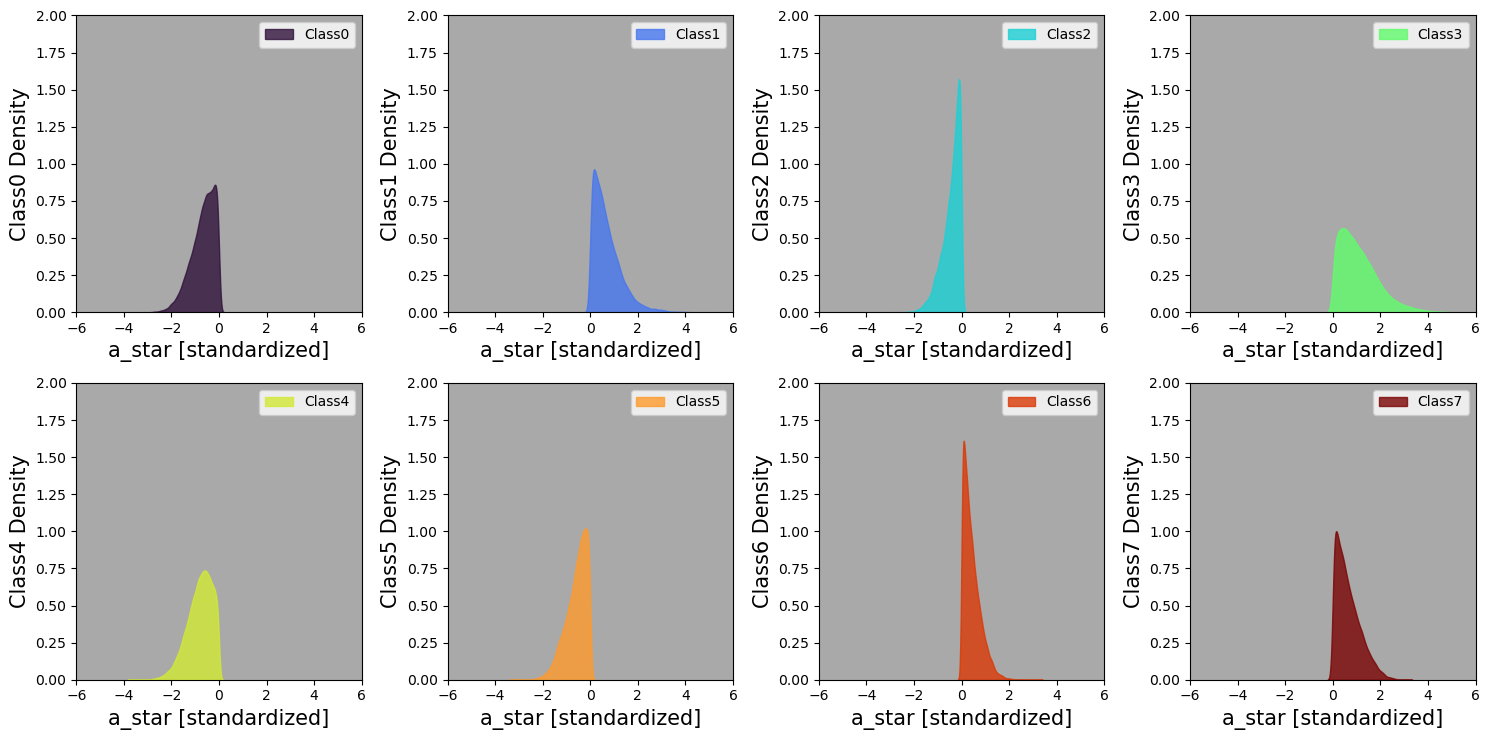

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7.5))
ax = ax.flatten()
for i in range(8):
    plot_classKDE(class_num=i, data_support=a_support, data_kde=a_kde, tt='a_star', ax=ax[i])
plt.tight_layout();

### クラスごとの b_star [standardized] 密度曲線

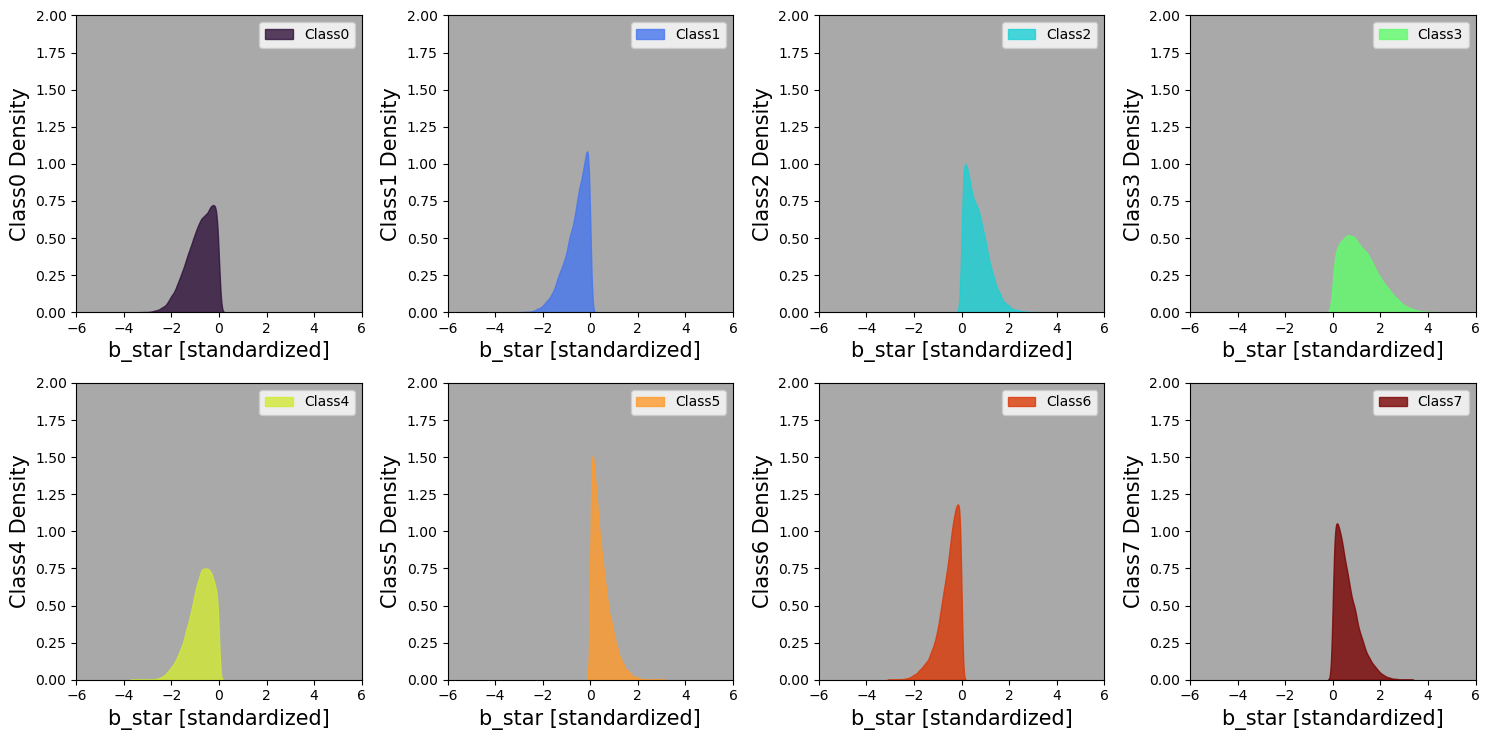

In [17]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7.5))
ax = ax.flatten()
for i in range(8):
    plot_classKDE(class_num=i, data_support=b_support, data_kde=b_kde, tt='b_star', ax=ax[i])
plt.tight_layout();